In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from geotext import GeoText
import itertools
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.manifold import MDS
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import cosine_distances

## Read review data

In [2]:
raw_data = pd.read_csv('AirCanada_review_raw.csv').drop('Unnamed: 0', axis=1)

In [3]:
raw_data

,title,user,user_type,review,publish_date,Type Of Traveller,Seat Type,Route,Date Flown,Seat Comfort,Cabin Staff Service,Food & Beverages,Inflight Entertainment,Ground Service,Wifi & Connectivity,Value For Money,page
0,24 hour delay which was not acceptable,Tony Harris,TripVerified,Flight from Sydney to Montreal cancelled on ...,6th February 2022,Business,Economy Class,Toronto to Vancouver,Feb-22,1,1,0,0,1,0,1,1
1,Worst airline ever,S Deane,TripVerified,Air Canada’s website booked me with another ...,3rd February 2022,Solo Leisure,Economy Class,Tokyo to Seattle via Seoul / Vancouver,Feb-22,0,0,0,0,0,0,1,1
2,the staff had no power to act,Collins Mazraani,TripVerified,I had booked business class for my mother an...,27th January 2022,Family Leisure,Economy Class,London to Montreal,Jan-22,2,3,1,2,1,4,2,1
3,Absolutely the worst airline,Shawn Holden,NotVerified,Houston to Prince George. They cancelled my f...,25th January 2022,Family Leisure,Economy Class,Houston to Prince George,Feb-21,1,1,0,0,1,0,1,1
4,I was not reimbursed for charges,G Ragami,TripVerified,Air Canada cancelled my flights twice so I h...,18th January 2022,Solo Leisure,Economy Class,Saskatoon to Chicago via Toronto,Dec-21,2,2,2,0,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1639,Air Canada customer review,F Hryn,Not Verified,YXE-YYZ-DUB-CPH CPH-YYZ-YXE in economy. Paid a...,8th September 2013,NaN,Economy Class,NaN,NaN,4,3,4,3,0,0,5,164
1640,Air Canada customer review,Em Vittorio,Not Verified,I flew YYZ-WAW with a stop in FRA. The YYZ-FRA...,8th September 2013,NaN,Economy Class,NaN,NaN,4,4,4,5,0,0,5,165
1641,Air Canada customer review,N McCrohan,Not Verified,AC 895 Dublin Ireland to Toronto. Good check i...,5th September 2013,NaN,Economy Class,NaN,NaN,1,1,1,2,0,0,1,165
1642,Air Canada customer review,Carole Ruxton,Not Verified,Flight on 22nd August 2013 Dublin to Toronto a...,5th September 2013,NaN,Economy Class,NaN,NaN,4,2,1,3,0,0,2,165


## Airport data

In [4]:
# Airport info data
airports = pd.read_csv('airport_info.csv',keep_default_na=False)
airports['name'] = airports['name'].str.replace('Airport','')
airports.head()
airport_lookup = airports[['name','iata_code','iso_country','municipality']].copy()
airport_lookup.shape

(8817, 4)

## Extract flight route for comments that has entires in Route

### replace airport code to city

In [5]:
def code_to_city(text, code_info):
    airport_code = code_info['iata_code']
    airport_city = code_info['municipality']
    for i,code in enumerate(airport_code):
        if code in text:
            city = airport_city[i]
            text = text.replace(code, city)
    return text

In [6]:
to_city = lambda x: code_to_city(x,airport_lookup)

In [7]:
route_data = raw_data.loc[~raw_data.Route.isnull()].reset_index(drop=True)

In [8]:
route_data['Route'] = route_data['Route'].apply(to_city)

In [9]:
route_series = route_data['Route'].to_list()

In [10]:
def get_list_of_cities(routes):
    output = {'from':[],'to':[],'transfer':[]}
    for i,route in enumerate(routes):
        # ind 0: from
        # ind 1: to
        # ind 2: transfer
        #route_cities = [0] * 3
        if ' to ' in route:
            split_places_from = route.split(' to ')
            output['from'].append(split_places_from[0].strip())
            if 'via' in route:
                split_places_to = split_places_from[1].split(' via ')
                output['to'].append(split_places_to[0].strip())
                if '/' in route:
                    if ' / ' in route:
                        transfer_lst = split_places_to[1].split(' / ')
                    else:
                        transfer_lst = split_places_to[1].split('/')
                    output['transfer'].append(transfer_lst)
                else:
                    output['transfer'].append([split_places_to[1].strip()])
            else:
                if len(split_places_from) > 1:
                    output['to'].append(split_places_from[1].strip())
                    output['transfer'].append(np.nan)
                else:
                    print("Formatting issue with", str(i)+":",route)
                    output['from'].append(np.nan)
                    output['to'].append(np.nan)
                    output['transfer'].append(np.nan)
        else:
            if '-' in route:
                split_places_from = [x.strip() for x in route.split('-')]
                for j,city in enumerate(split_places_from):
                    if ',' in city:
                        split_places_from[j] = city.split(',')[0].strip()
                output['from'].append(split_places_from[0].strip())
                output['to'].append(split_places_from[-1].strip())
                output['transfer'].append(split_places_from[1:-1])
            else:
                print("Formatting issue with", str(i)+":",route)
                output['from'].append(np.nan)
                output['to'].append(np.nan)
                output['transfer'].append(np.nan)
    return output

In [11]:
route_info = get_list_of_cities(route_series)

Formatting issue with 1152: Torontoto New York


In [12]:
review_route = pd.DataFrame(route_info)

In [13]:
review_route.loc[1152,:]

from        NaN
to          NaN
transfer    NaN
Name: 1152, dtype: object

In [14]:
# Deal with the exception
cities = [x.strip() for x in route_series[1152].split('to')]
city_lst = [cities[0]+'to',cities[-1],np.nan]
city_lst
review_route.loc[1152,:] = city_lst 

In [15]:
review_route.loc[1152,:]

from         Toronto
to          New York
transfer         NaN
Name: 1152, dtype: object

### Concatinate three columns to get mentions of airports.

In [16]:
review_route.loc[review_route['transfer'].isnull(),['transfer']] = review_route.loc[review_route['transfer'].isnull(),'transfer'].apply(lambda x: [])

In [17]:
review_route['cities'] = review_route['from'].apply(lambda x: [x]) + review_route['to'].apply(lambda x: [x]) + review_route['transfer']

In [18]:
route_data_complete = route_data.join(review_route)
route_data_complete.head()

,title,user,user_type,review,publish_date,Type Of Traveller,Seat Type,Route,Date Flown,Seat Comfort,...,Food & Beverages,Inflight Entertainment,Ground Service,Wifi & Connectivity,Value For Money,page,from,to,transfer,cities
0,24 hour delay which was not acceptable,Tony Harris,TripVerified,Flight from Sydney to Montreal cancelled on ...,6th February 2022,Business,Economy Class,Toronto to Vancouver,Feb-22,1,...,0,0,1,0,1,1,Toronto,Vancouver,[],"[Toronto, Vancouver]"
1,Worst airline ever,S Deane,TripVerified,Air Canada’s website booked me with another ...,3rd February 2022,Solo Leisure,Economy Class,Tokyo to Seattle via Seoul / Vancouver,Feb-22,0,...,0,0,0,0,1,1,Tokyo,Seattle,"[Seoul, Vancouver]","[Tokyo, Seattle, Seoul, Vancouver]"
2,the staff had no power to act,Collins Mazraani,TripVerified,I had booked business class for my mother an...,27th January 2022,Family Leisure,Economy Class,London to Montreal,Jan-22,2,...,1,2,1,4,2,1,London,Montreal,[],"[London, Montreal]"
3,Absolutely the worst airline,Shawn Holden,NotVerified,Houston to Prince George. They cancelled my f...,25th January 2022,Family Leisure,Economy Class,Houston to Prince George,Feb-21,1,...,0,0,1,0,1,1,Houston,Prince George,[],"[Houston, Prince George]"
4,I was not reimbursed for charges,G Ragami,TripVerified,Air Canada cancelled my flights twice so I h...,18th January 2022,Solo Leisure,Economy Class,Saskatoon to Chicago via Toronto,Dec-21,2,...,2,0,1,0,1,1,Saskatoon,Chicago,[Toronto],"[Saskatoon, Chicago, Toronto]"


## Extract route from review text
Old reviews do not have a title (they have the same title). There is no clear pattern on how the customers would mention their routes, or their routes are very complicated/round trip that hard to detect the actual route Air Canada is involved.

In [19]:
old_data = raw_data.loc[raw_data.Route.isnull()]

In [20]:
old_data.columns

Index(['title', 'user', 'user_type', 'review', 'publish_date',
       'Type Of Traveller', 'Seat Type', 'Route', 'Date Flown', 'Seat Comfort',
       'Cabin Staff Service', 'Food & Beverages', 'Inflight Entertainment',
       'Ground Service', 'Wifi & Connectivity', 'Value For Money', 'page'],
      dtype='object')

In [21]:
def extract_route_geo(text,airports):
    airport_code = airports['iata_code']
    airport_city = airports['municipality']
    extracted_cities = []
    for i,code in enumerate(airport_code):
        if code in text:
            city = airport_city[i]
            extracted_cities.append(city)
    return np.unique(extracted_cities)

In [22]:
to_places_lst = lambda x: extract_route_geo(x,airport_lookup)

In [23]:
old_data['cities'] = old_data['review'].apply(to_places_lst)

/var/folders/qd/mwbvwnnn27n7mvvwgw8sy4_40000gn/T/ipykernel_79950/3619775763.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  old_data['cities'] = old_data['review'].apply(to_places_lst)


In [24]:
old_data

,title,user,user_type,review,publish_date,Type Of Traveller,Seat Type,Route,Date Flown,Seat Comfort,Cabin Staff Service,Food & Beverages,Inflight Entertainment,Ground Service,Wifi & Connectivity,Value For Money,page,cities
44,reached the gate I was 3-4 mins late,Pawandeep Dhunna,NotVerified,I have bought Business flight passes from Ai...,5th September 2021,Business,Business Class,NaN,Aug-21,0,0,0,0,1,0,2,5,[]
52,over four months to get a refund,Richard Lavallee,TripVerified,Still not sure why it is taking over four mo...,25th August 2021,Couple Leisure,Economy Class,NaN,Mar-21,0,0,0,0,0,0,1,6,[]
101,turning me into a customer for life,Olivia Jain,NotVerified,"I Booked a Ticket Through +1 855-948-3661 , ...",18th June 2020,Couple Leisure,Business Class,NaN,May-20,4,4,3,4,4,5,4,11,[]
118,flight does not count as canceled,S Johnson,NotVerified,My wife and I were going to have our honeymo...,9th April 2020,Couple Leisure,Economy Class,NaN,Apr-20,0,0,0,0,0,0,1,12,[]
1205,Air Canada customer review,M Alexander,Not Verified,AC761 to San Francisco AC 760 to Montreal. May...,6th June 2015,NaN,Economy Class,NaN,NaN,5,5,3,4,0,0,5,121,[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1639,Air Canada customer review,F Hryn,Not Verified,YXE-YYZ-DUB-CPH CPH-YYZ-YXE in economy. Paid a...,8th September 2013,NaN,Economy Class,NaN,NaN,4,3,4,3,0,0,5,164,"[Copenhagen, Dublin, Saskatoon, Toronto]"
1640,Air Canada customer review,Em Vittorio,Not Verified,I flew YYZ-WAW with a stop in FRA. The YYZ-FRA...,8th September 2013,NaN,Economy Class,NaN,NaN,4,4,4,5,0,0,5,165,"[Frankfurt, Toronto, Warsaw]"
1641,Air Canada customer review,N McCrohan,Not Verified,AC 895 Dublin Ireland to Toronto. Good check i...,5th September 2013,NaN,Economy Class,NaN,NaN,1,1,1,2,0,0,1,165,[]
1642,Air Canada customer review,Carole Ruxton,Not Verified,Flight on 22nd August 2013 Dublin to Toronto a...,5th September 2013,NaN,Economy Class,NaN,NaN,4,2,1,3,0,0,2,165,[]


## Count cities mentioned
We focus on the count of cities as Air Canada at least participated one part of the trip.

In [25]:
target_data = pd.concat([route_data_complete[['user_type','review','Seat Type','Date Flown','cities']],old_data[['user_type','review','Seat Type','Date Flown','cities']]])

In [26]:
target_data.head(50)

,user_type,review,Seat Type,Date Flown,cities
0,TripVerified,Flight from Sydney to Montreal cancelled on ...,Economy Class,Feb-22,"[Toronto, Vancouver]"
1,TripVerified,Air Canada’s website booked me with another ...,Economy Class,Feb-22,"[Tokyo, Seattle, Seoul, Vancouver]"
2,TripVerified,I had booked business class for my mother an...,Economy Class,Jan-22,"[London, Montreal]"
3,NotVerified,Houston to Prince George. They cancelled my f...,Economy Class,Feb-21,"[Houston, Prince George]"
4,TripVerified,Air Canada cancelled my flights twice so I h...,Economy Class,Dec-21,"[Saskatoon, Chicago, Toronto]"
5,TripVerified,During a snow storm we sat on plane at gate ...,Economy Class,Jan-22,"[Toronto, Vancouver]"
6,TripVerified,"The seats were comfy, the staff were nice, th...",Economy Class,Jan-22,"[Montreal, Edmonton]"
7,TripVerified,Montreal to Los Angeles. Air Canada always go...,Premium Economy,Jan-22,"[Montreal, Los Angeles]"
8,TripVerified,The flight time was changed at least 3 times...,Economy Class,Dec-21,"[Toronto, Doha]"
9,TripVerified,"Frustrating to say the least, I had to pack ...",Economy Class,Jan-22,"[Orlando, Vancouver, Montreal]"


In [27]:
cities_list = target_data['cities'].to_list()
flattened_cities = list(itertools.chain(*cities_list))
cities_count = Counter(flattened_cities)

In [28]:
counter_pd = pd.DataFrame([[city,count] for city,count in cities_count.items()],columns=['city','count'])

### Top 20 cities in Air Canada reviews

In [29]:
top_20_cities = counter_pd.sort_values(by='count',ascending=False).head(20)

In [30]:
top_20_cities

,city,count
0,Toronto,811
1,Vancouver,381
6,Montreal,239
5,London,160
18,Calgary,131
38,Ottawa,68
11,Edmonton,59
23,Frankfurt,56
12,Los Angeles,54
2,Tokyo,54


In [31]:
combos = list(itertools.combinations(top_20_cities['city'].to_list(), 2))

In [32]:
def combos_count(combo_lst,data):
    mention_city = data['cities'].to_list()
    count_lst = []
    for combo in combo_lst:
        count = 0
        for i,mentined_city in enumerate(mention_city):
            if combo[0] in mentined_city:
                if combo[1] in mentined_city:
                    count += 1
        count_lst.append(count)
    return count_lst

In [33]:
combo_count_lst = combos_count(combos,target_data)

/var/folders/qd/mwbvwnnn27n7mvvwgw8sy4_40000gn/T/ipykernel_79950/371493823.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if combo[0] in mentined_city:


In [34]:
cities_combo_count = pd.DataFrame({'combo':combos,'count':combo_count_lst})

In [35]:
cities_combo_count 

,combo,count
0,"(Toronto, Vancouver)",109
1,"(Toronto, Montreal)",67
2,"(Toronto, London)",73
3,"(Toronto, Calgary)",42
4,"(Toronto, Ottawa)",31
...,...,...
185,"(Chicago, Paris)",1
186,"(Chicago, Winnipeg)",1
187,"(Rome, Paris)",0
188,"(Rome, Winnipeg)",1


## Identify Domestic line vs International line

Assumption: Many countries have cities that share the same name. In our search we assume which ever pops out first in search is its corresponding country.

In [36]:
def identify_flight_type(lst_of_dest, geo_lookup):
    if len(lst_of_dest) == 0:
        return np.nan
    else:
        country_lst = []
        for city in lst_of_dest:
            country_series = geo_lookup[geo_lookup.municipality == city]['iso_country']
            if len(country_series) > 0:
                country = country_series.iloc[0]
                country_lst.append(country)
        unique_countries = np.unique(country_lst)
        if len(unique_countries) > 1:
            return 'International'
        else:
            if 'CA' in unique_countries:
                return 'Domestic'
            else:
                return 'International'
        

In [37]:
get_flight_type = lambda x: identify_flight_type(x,airport_lookup)

In [38]:
target_data['flight_type'] = target_data['cities'].apply(get_flight_type)

/var/folders/qd/mwbvwnnn27n7mvvwgw8sy4_40000gn/T/ipykernel_79950/770904818.py:15: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'CA' in unique_countries:


<AxesSubplot:xlabel='flight_type', ylabel='Count'>

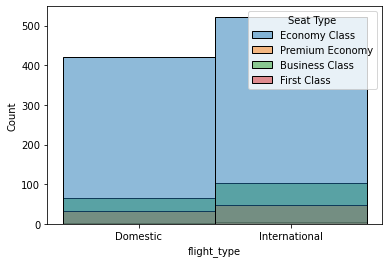

In [39]:
sns.histplot(data = target_data.dropna(),x = 'flight_type', hue = 'Seat Type')

### Add flight types to co-mention

In [40]:
cities_combo_count['flight_type'] = cities_combo_count['combo'].apply(get_flight_type)

In [41]:
nonzero_combos = cities_combo_count[cities_combo_count['count']>0]

[[Text(0, 0, ''),
  Text(1, 0, ''),
  Text(2, 0, ''),
  Text(3, 0, ''),
  Text(4, 0, ''),
  Text(5, 0, ''),
  Text(6, 0, ''),
  Text(7, 0, ''),
  Text(8, 0, ''),
  Text(9, 0, ''),
  Text(10, 0, ''),
  Text(11, 0, ''),
  Text(12, 0, ''),
  Text(13, 0, ''),
  Text(14, 0, ''),
  Text(15, 0, ''),
  Text(16, 0, ''),
  Text(17, 0, ''),
  Text(18, 0, ''),
  Text(19, 0, ''),
  Text(20, 0, ''),
  Text(21, 0, ''),
  Text(22, 0, ''),
  Text(23, 0, ''),
  Text(24, 0, ''),
  Text(25, 0, ''),
  Text(26, 0, ''),
  Text(27, 0, ''),
  Text(28, 0, ''),
  Text(29, 0, ''),
  Text(30, 0, ''),
  Text(31, 0, ''),
  Text(32, 0, ''),
  Text(33, 0, ''),
  Text(34, 0, ''),
  Text(35, 0, ''),
  Text(36, 0, ''),
  Text(37, 0, ''),
  Text(38, 0, ''),
  Text(39, 0, ''),
  Text(40, 0, ''),
  Text(41, 0, ''),
  Text(42, 0, ''),
  Text(43, 0, ''),
  Text(44, 0, ''),
  Text(45, 0, ''),
  Text(46, 0, ''),
  Text(47, 0, ''),
  Text(48, 0, ''),
  Text(49, 0, ''),
  Text(50, 0, ''),
  Text(51, 0, ''),
  Text(52, 0, ''),
  T

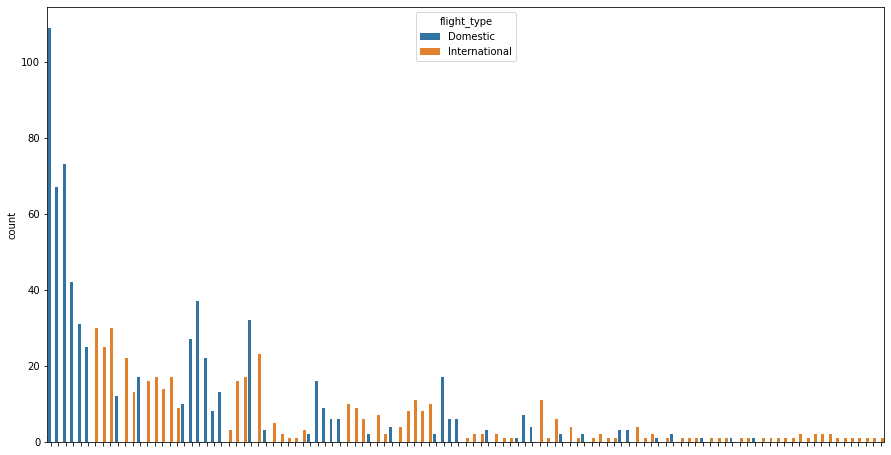

In [42]:
plt.figure(figsize = (15,8))
bar_plt = sns.barplot(data=nonzero_combos, x = 'combo', y = 'count',hue="flight_type")
bar_plt.set(xlabel=None)
bar_plt.set(xticklabels=[])

## Lift and MDS

In [43]:
def get_city1_count(t,cities_count):
    city1 = t[0]
    city1_count = cities_count.loc[cities_count.city == city1,'count'].iloc[0]
    return city1_count

def get_city2_count(t,cities_count):
    city2 = t[1]
    city2_count = cities_count.loc[cities_count.city == city2,'count'].iloc[0]
    return city2_count

In [44]:
get_city1_n = lambda x: get_city1_count(x,top_20_cities)
get_city2_n = lambda x: get_city2_count(x,top_20_cities)

In [45]:
cities_combo_count['city1_n'] = cities_combo_count['combo'].apply(get_city1_n)
cities_combo_count['city2_n'] = cities_combo_count['combo'].apply(get_city2_n)

In [46]:
N = target_data.shape[0]

In [47]:
cities_combo_count['lift'] = (cities_combo_count['count']/(cities_combo_count['city1_n']*cities_combo_count['city2_n'])) * N

In [48]:
cities_combo_count.sort_values(by='lift', ascending=False).head(10)

,combo,count,flight_type,city1_n,city2_n,lift
27,"(Vancouver, Sydney)",32,Domestic,381,37,3.731858
50,"(Montreal, Chicago)",11,International,239,27,2.802417
29,"(Vancouver, Hong Kong)",23,International,381,36,2.756780
52,"(Montreal, Paris)",10,International,239,26,2.645639
188,"(Rome, Winnipeg)",1,International,26,24,2.634615
144,"(Tokyo, Winnipeg)",2,International,54,24,2.537037
186,"(Chicago, Winnipeg)",1,International,27,24,2.537037
72,"(Calgary, Frankfurt)",11,International,131,56,2.465104
184,"(Chicago, Rome)",1,International,27,26,2.341880
185,"(Chicago, Paris)",1,International,27,26,2.341880


In [49]:
get_city1 = lambda x: x[0]
get_city2 = lambda x: x[1]
cities_combo_count['city1'] = cities_combo_count['combo'].apply(get_city1)
cities_combo_count['city2'] = cities_combo_count['combo'].apply(get_city2)

In [50]:
cities_combo_count

,combo,count,flight_type,city1_n,city2_n,lift,city1,city2
0,"(Toronto, Vancouver)",109,Domestic,811,381,0.579939,Toronto,Vancouver
1,"(Toronto, Montreal)",67,Domestic,811,239,0.568274,Toronto,Montreal
2,"(Toronto, London)",73,Domestic,811,160,0.924877,Toronto,London
3,"(Toronto, Calgary)",42,Domestic,811,131,0.649919,Toronto,Calgary
4,"(Toronto, Ottawa)",31,Domestic,811,68,0.924131,Toronto,Ottawa
...,...,...,...,...,...,...,...,...
185,"(Chicago, Paris)",1,International,27,26,2.341880,Chicago,Paris
186,"(Chicago, Winnipeg)",1,International,27,24,2.537037,Chicago,Winnipeg
187,"(Rome, Paris)",0,International,26,26,0.000000,Rome,Paris
188,"(Rome, Winnipeg)",1,International,26,24,2.634615,Rome,Winnipeg


### MDS Plot

In [51]:
top_20_cities_lst=top_20_cities['city'].to_list()

In [52]:
def construct_dissimilarity_matrix(df,city_lst):
    lift_matrix = {}
    for city_a in city_lst:
        #print('A:',brand_a)
        lift_matrix[city_a] = []
        sub_lift_df1 = df[df.city1 == city_a]
        for city_b in city_lst:
            #print('B:',brand_b)
            sub_lift_df2 = sub_lift_df1[sub_lift_df1.city2 == city_b]
            if len(sub_lift_df2) == 0:
                #try opposite order combo
                sub_lift_df3 = df[df.city2 == city_a]
                sub_lift_df4 = sub_lift_df3[sub_lift_df3.city1 == city_b]
                if len(sub_lift_df4) > 0:
                    value_0 = sub_lift_df4['lift'].values[0]
                    if value_0 != 0:
                        lift_matrix[city_a].append(1/value_0)
                    else:
                        lift_matrix[city_a].append(value_0)
                else:
                    lift_matrix[city_a].append(0)
            else:
                value_1 = sub_lift_df2['lift'].values[0]
                if value_1 != 0:
                    lift_matrix[city_a].append(1/value_1)
                else:
                    lift_matrix[city_a].append(value_1)
    return lift_matrix

In [53]:
dissimilarity_df = pd.DataFrame(construct_dissimilarity_matrix(cities_combo_count,top_20_cities_lst))

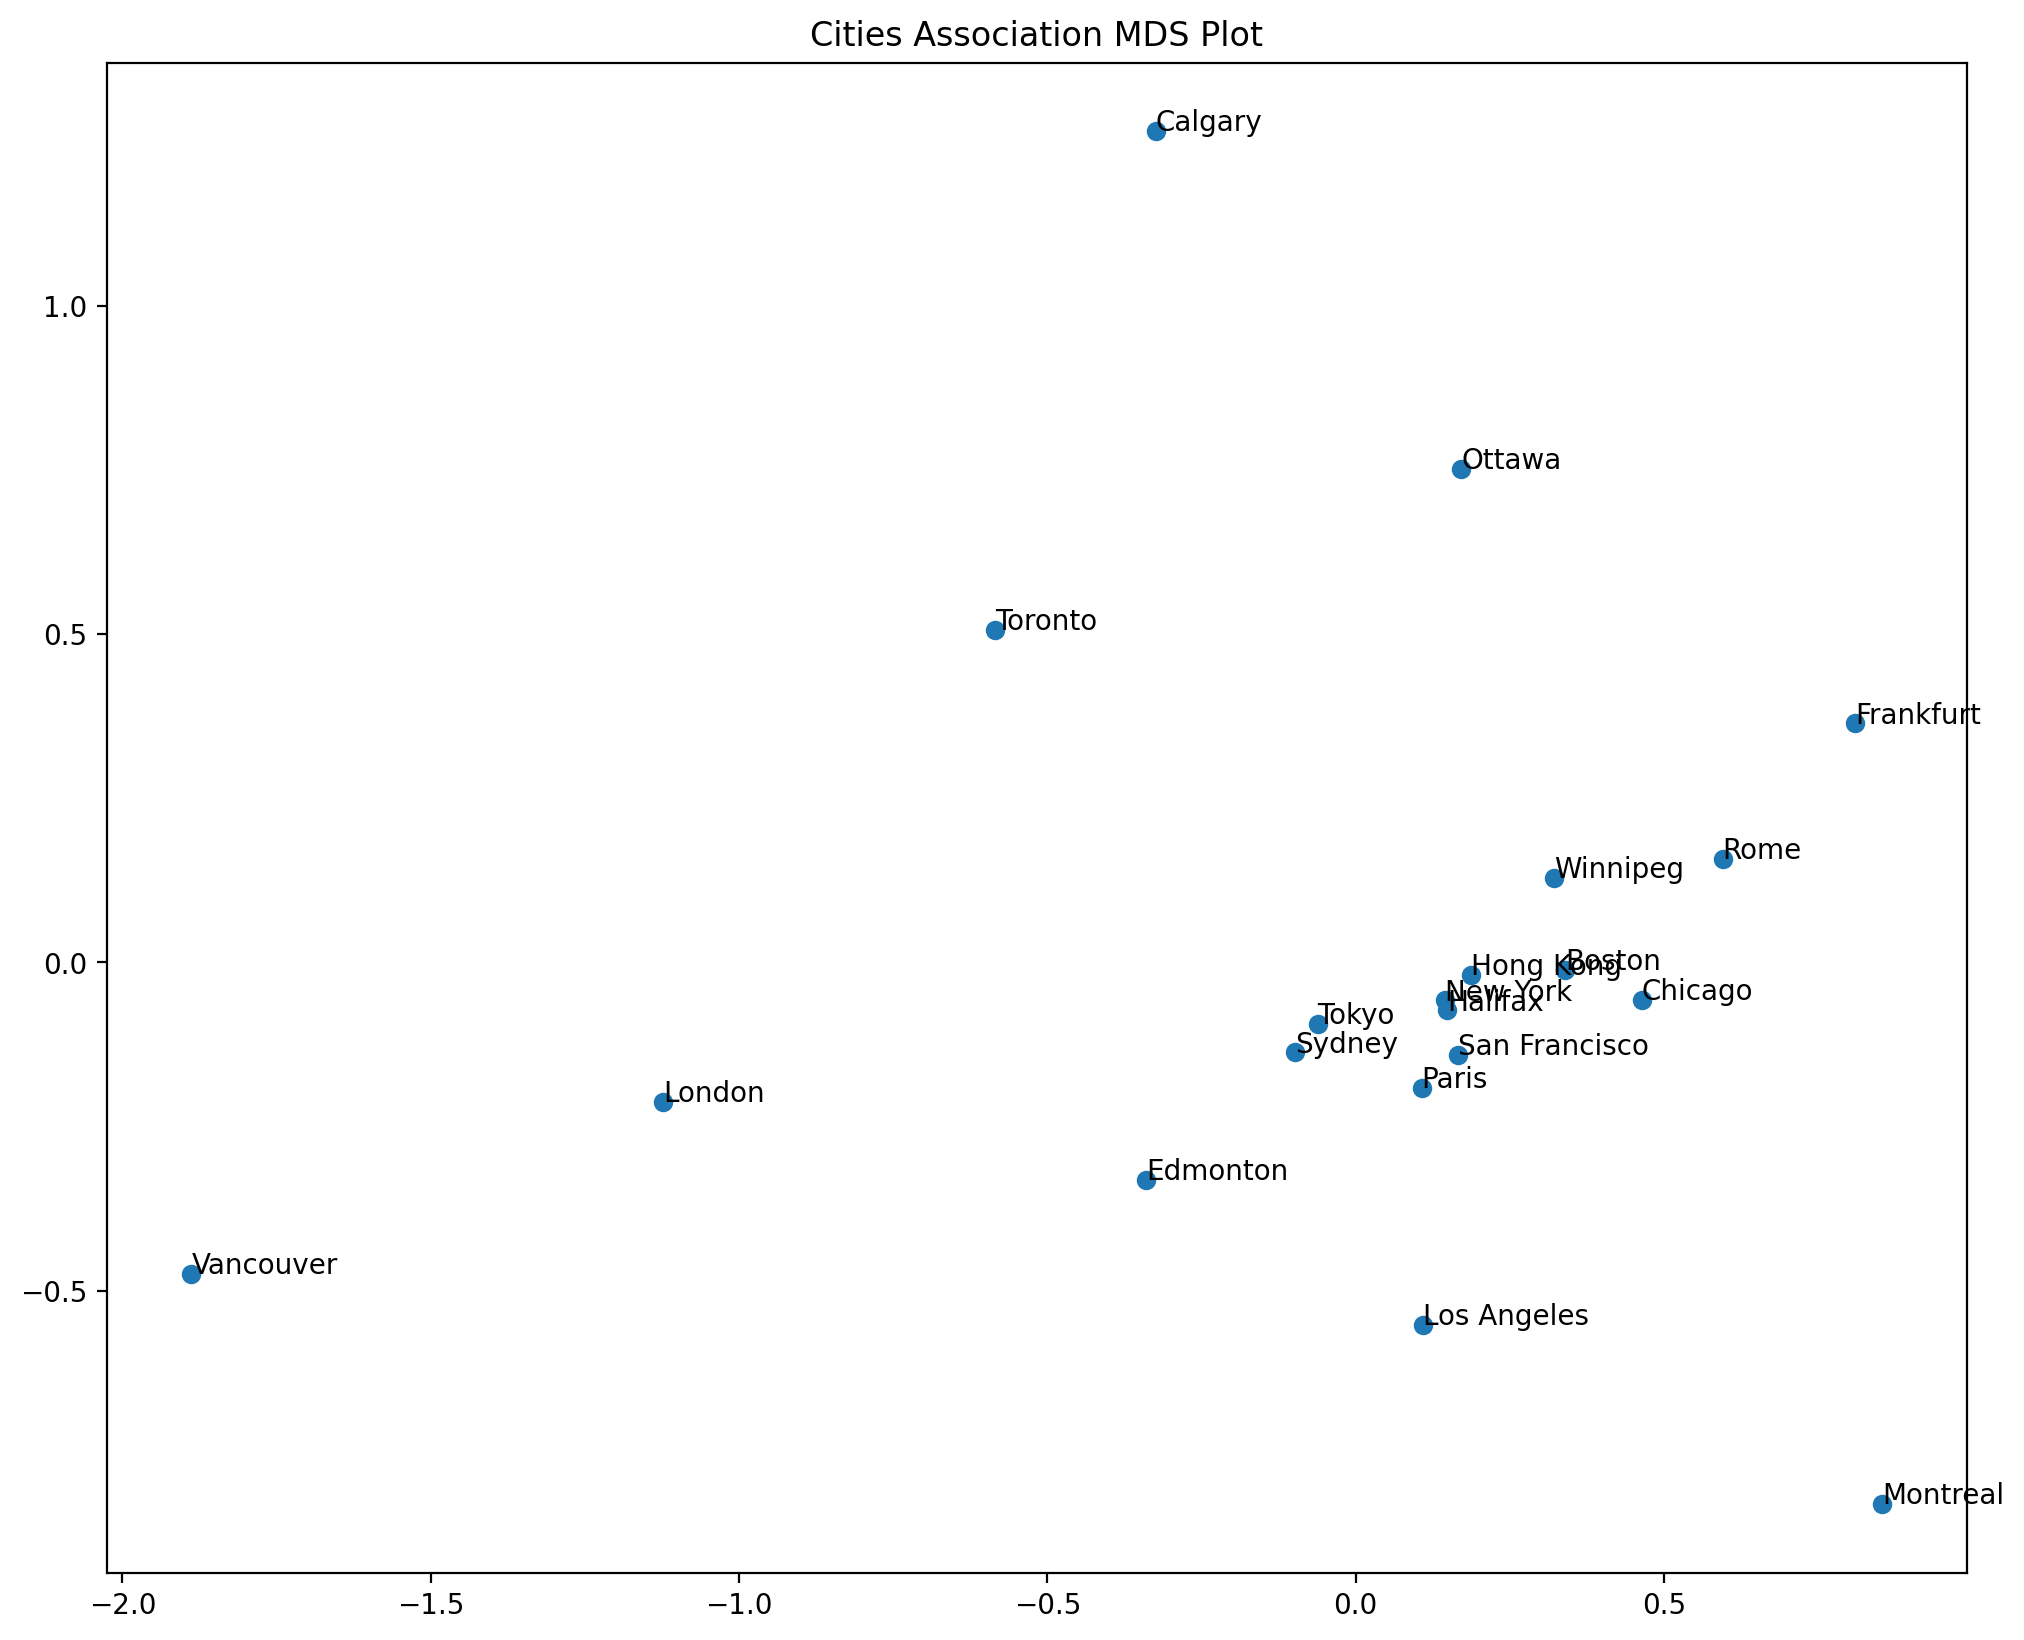

In [54]:
mds = MDS(n_components=2,random_state=0, dissimilarity='precomputed')
data_transformed = mds.fit_transform(dissimilarity_df)
figure(figsize=(12, 10), dpi=200)
plt.scatter(data_transformed[:,0],data_transformed[:,1])
plt.title('Cities Association MDS Plot')
for i, txt in enumerate(top_20_cities_lst):
    plt.annotate(txt, (data_transformed[i,0], data_transformed[i,1]))
plt.show()

## Review text processing

We will be deviding text into two portion then assign different weights to title and review.

In [55]:
raw_data.columns

Index(['title', 'user', 'user_type', 'review', 'publish_date',
       'Type Of Traveller', 'Seat Type', 'Route', 'Date Flown', 'Seat Comfort',
       'Cabin Staff Service', 'Food & Beverages', 'Inflight Entertainment',
       'Ground Service', 'Wifi & Connectivity', 'Value For Money', 'page'],
      dtype='object')

In [56]:
review_data = raw_data[['title','review']]
review_data = review_data.copy()
review_data['concate_review'] = np.where(review_data['title']=='Air Canada customer review',review_data['review'],
                                         review_data['title']+'.' +review_data['review'])

In [57]:
review_data

,title,review,concate_review
0,24 hour delay which was not acceptable,Flight from Sydney to Montreal cancelled on ...,24 hour delay which was not acceptable. Fligh...
1,Worst airline ever,Air Canada’s website booked me with another ...,Worst airline ever. Air Canada’s website book...
2,the staff had no power to act,I had booked business class for my mother an...,the staff had no power to act. I had booked b...
3,Absolutely the worst airline,Houston to Prince George. They cancelled my f...,Absolutely the worst airline. Houston to Princ...
4,I was not reimbursed for charges,Air Canada cancelled my flights twice so I h...,I was not reimbursed for charges. Air Canada ...
...,...,...,...
1639,Air Canada customer review,YXE-YYZ-DUB-CPH CPH-YYZ-YXE in economy. Paid a...,YXE-YYZ-DUB-CPH CPH-YYZ-YXE in economy. Paid a...
1640,Air Canada customer review,I flew YYZ-WAW with a stop in FRA. The YYZ-FRA...,I flew YYZ-WAW with a stop in FRA. The YYZ-FRA...
1641,Air Canada customer review,AC 895 Dublin Ireland to Toronto. Good check i...,AC 895 Dublin Ireland to Toronto. Good check i...
1642,Air Canada customer review,Flight on 22nd August 2013 Dublin to Toronto a...,Flight on 22nd August 2013 Dublin to Toronto a...


### Remove stop words

In [58]:
review_data['remove_stopword']= review_data["concate_review"].str.lower().tolist()

english_stop_words = stopwords.words('english')
def remove_stop_words(corpus):
    removed_stop_words = []
    for review in corpus:
        removed_stop_words.append(
            ' '.join([word for word in review.split() 
                      if word not in english_stop_words and word.isalpha()])
        )
    return removed_stop_words

review_data['remove_stopword'] = remove_stop_words(review_data['remove_stopword'])


### Tokenize

In [59]:
pos_dict = {'J':wordnet.ADJ, 'V':wordnet.VERB, 'N':wordnet.NOUN, 'R':wordnet.ADV}
def token_stop_pos(text):
    tags = nltk.pos_tag(word_tokenize(text))
    newlist = []
    for word, tag in tags:
        newlist.append(tuple([word.lower(), pos_dict.get(tag[0])]))
    return newlist

review_data['pos'] = review_data['remove_stopword'].apply(token_stop_pos)

In [60]:
review_data

,title,review,concate_review,remove_stopword,pos
0,24 hour delay which was not acceptable,Flight from Sydney to Montreal cancelled on ...,24 hour delay which was not acceptable. Fligh...,hour delay flight sydney montreal cancelled au...,"[(hour, n), (delay, n), (flight, n), (sydney, ..."
1,Worst airline ever,Air Canada’s website booked me with another ...,Worst airline ever. Air Canada’s website book...,worst airline air website booked another fligh...,"[(worst, a), (airline, n), (air, n), (website,..."
2,the staff had no power to act,I had booked business class for my mother an...,the staff had no power to act. I had booked b...,staff power booked business class mother booke...,"[(staff, n), (power, n), (booked, v), (busines..."
3,Absolutely the worst airline,Houston to Prince George. They cancelled my f...,Absolutely the worst airline. Houston to Princ...,absolutely worst houston prince cancelled flig...,"[(absolutely, r), (worst, a), (houston, n), (p..."
4,I was not reimbursed for charges,Air Canada cancelled my flights twice so I h...,I was not reimbursed for charges. Air Canada ...,reimbursed air canada cancelled flights twice ...,"[(reimbursed, v), (air, n), (canada, n), (canc..."
...,...,...,...,...,...
1639,Air Canada customer review,YXE-YYZ-DUB-CPH CPH-YYZ-YXE in economy. Paid a...,YXE-YYZ-DUB-CPH CPH-YYZ-YXE in economy. Paid a...,paid excellent price flight toronto uneventful...,"[(paid, v), (excellent, a), (price, n), (fligh..."
1640,Air Canada customer review,I flew YYZ-WAW with a stop in FRA. The YYZ-FRA...,I flew YYZ-WAW with a stop in FRA. The YYZ-FRA...,flew stop portion operated ac july happy servi...,"[(flew, a), (stop, a), (portion, n), (operated..."
1641,Air Canada customer review,AC 895 Dublin Ireland to Toronto. Good check i...,AC 895 Dublin Ireland to Toronto. Good check i...,ac dublin ireland good check flight booked air...,"[(ac, a), (dublin, n), (ireland, n), (good, a)..."
1642,Air Canada customer review,Flight on 22nd August 2013 Dublin to Toronto a...,Flight on 22nd August 2013 Dublin to Toronto a...,flight august dublin toronto return cabin crew...,"[(flight, n), (august, n), (dublin, n), (toron..."


### Lemmatization

In [61]:
def lemmatize(pos_data):
    wl = WordNetLemmatizer()
    lemma_rew = " "
    for word, pos in pos_data:
        if not pos:
            lemma = word
            lemma_rew = lemma_rew + " " + lemma
        else:
            lemma = wl.lemmatize(word, pos=pos)
            lemma_rew = lemma_rew + " " + lemma
    return lemma_rew

In [62]:
review_data['lemmizated'] = review_data['pos'].apply(lemmatize)

### Sentiment Score using Blob API

In [63]:
def datablob(lemma):
    return TextBlob(lemma).sentiment

In [64]:
review_data['blob_sent'] = review_data['lemmizated'].apply(datablob)

### Subjective reviews

In [65]:
subjective_reviews = review_data[review_data['blob_sent'].str[1] > 0.5]

In [66]:
len(subjective_reviews)

761

Strictly keeping subjective reviews cause us losing a lot of records. In this case we still keep the scope and consider all possible reviews.

### Seperate positive and negative reviews

In [67]:
review_data['sent'] = np.where(review_data['blob_sent'].str[0] > 0, 'Positive', 'Negative')

### Add review info

In [68]:
review_data_route = review_data.join(raw_data[['Seat Type', 'publish_date']])

In [69]:
review_data_route = review_data_route.join(target_data[['cities','flight_type']])

In [70]:
review_data_route['transfers'] = np.where(review_data_route['cities'].str.len() > 2, review_data_route['cities'].str.len(), np.nan)

In [71]:
review_data_route

,title,review,concate_review,remove_stopword,pos,lemmizated,blob_sent,sent,Seat Type,publish_date,cities,flight_type,transfers
0,24 hour delay which was not acceptable,Flight from Sydney to Montreal cancelled on ...,24 hour delay which was not acceptable. Fligh...,hour delay flight sydney montreal cancelled au...,"[(hour, n), (delay, n), (flight, n), (sydney, ...",hour delay flight sydney montreal cancel aut...,"(0.0014880952380952408, 0.3985119047619047)",Positive,Economy Class,6th February 2022,"[Toronto, Vancouver]",Domestic,NaN
1,Worst airline ever,Air Canada’s website booked me with another ...,Worst airline ever. Air Canada’s website book...,worst airline air website booked another fligh...,"[(worst, a), (airline, n), (air, n), (website,...",bad airline air website book another flight ...,"(-0.0571428571428571, 0.5083333333333333)",Negative,Economy Class,3rd February 2022,"[Tokyo, Seattle, Seoul, Vancouver]",International,4.0
2,the staff had no power to act,I had booked business class for my mother an...,the staff had no power to act. I had booked b...,staff power booked business class mother booke...,"[(staff, n), (power, n), (booked, v), (busines...",staff power book business class mother book ...,"(0.07333333333333333, 0.6225)",Positive,Economy Class,27th January 2022,"[London, Montreal]",Domestic,NaN
3,Absolutely the worst airline,Houston to Prince George. They cancelled my f...,Absolutely the worst airline. Houston to Princ...,absolutely worst houston prince cancelled flig...,"[(absolutely, r), (worst, a), (houston, n), (p...",absolutely bad houston prince cancel flight ...,"(-0.2178571428571428, 0.33928571428571425)",Negative,Economy Class,25th January 2022,"[Houston, Prince George]",International,NaN
4,I was not reimbursed for charges,Air Canada cancelled my flights twice so I h...,I was not reimbursed for charges. Air Canada ...,reimbursed air canada cancelled flights twice ...,"[(reimbursed, v), (air, n), (canada, n), (canc...",reimburse air canada cancel flight twice pay...,"(0.4, 0.48333333333333334)",Positive,Economy Class,18th January 2022,"[Saskatoon, Chicago, Toronto]",International,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1639,Air Canada customer review,YXE-YYZ-DUB-CPH CPH-YYZ-YXE in economy. Paid a...,YXE-YYZ-DUB-CPH CPH-YYZ-YXE in economy. Paid a...,paid excellent price flight toronto uneventful...,"[(paid, v), (excellent, a), (price, n), (fligh...",pay excellent price flight toronto uneventfu...,"(0.1777777777777778, 0.5518518518518519)",Positive,Economy Class,8th September 2013,"[Copenhagen, Dublin, Saskatoon, Toronto]",International,4.0
1640,Air Canada customer review,I flew YYZ-WAW with a stop in FRA. The YYZ-FRA...,I flew YYZ-WAW with a stop in FRA. The YYZ-FRA...,flew stop portion operated ac july happy servi...,"[(flew, a), (stop, a), (portion, n), (operated...",flew stop portion operate ac july happy serv...,"(0.2723684210526316, 0.5192982456140351)",Positive,Economy Class,8th September 2013,"[Frankfurt, Toronto, Warsaw]",International,3.0
1641,Air Canada customer review,AC 895 Dublin Ireland to Toronto. Good check i...,AC 895 Dublin Ireland to Toronto. Good check i...,ac dublin ireland good check flight booked air...,"[(ac, a), (dublin, n), (ireland, n), (good, a)...",ac dublin ireland good check flight book air...,"(0.04494047619047617, 0.4288690476190476)",Positive,Economy Class,5th September 2013,[],NaN,NaN
1642,Air Canada customer review,Flight on 22nd August 2013 Dublin to Toronto a...,Flight on 22nd August 2013 Dublin to Toronto a...,flight august dublin toronto return cabin crew...,"[(flight, n), (august, n), (dublin, n), (toron...",flight august dublin toronto return cabin cr...,"(0.06893939393939397, 0.5340909090909091)",Positive,Economy Class,5th September 2013,[],NaN,NaN


### Seat type and sentiment

<AxesSubplot:xlabel='Seat Type', ylabel='Count'>

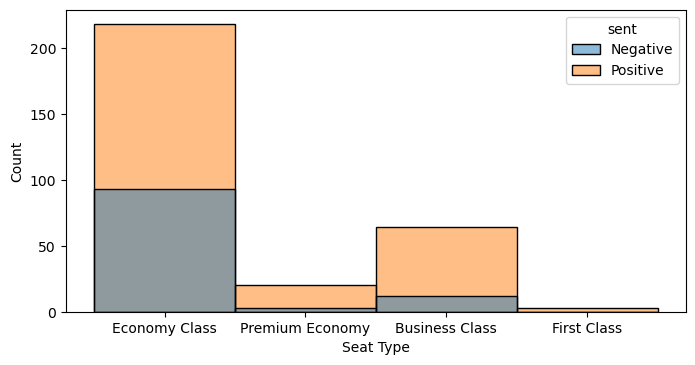

In [72]:
figure(figsize=(8, 4), dpi=100)
sns.histplot(data = review_data_route.dropna().reset_index(drop=True), x = 'Seat Type',hue = 'sent')

In [73]:
cabin_sent = review_data_route[['Seat Type','sent']
                                     ].groupby(['Seat Type','sent']
                                              ).agg({'sent':'count'}
                                                   ).rename(columns={'sent':'counts'}
                                                           ).reset_index()

In [74]:
canbin_sent_prop = pd.merge(cabin_sent, cabin_sent.groupby('Seat Type')[['counts']].sum().reset_index().rename(columns={'counts':'cabin_counts'}))

In [75]:
canbin_sent_prop['sent_prop'] = canbin_sent_prop['counts']/canbin_sent_prop['cabin_counts']

<AxesSubplot:xlabel='Seat Type', ylabel='sent_prop'>

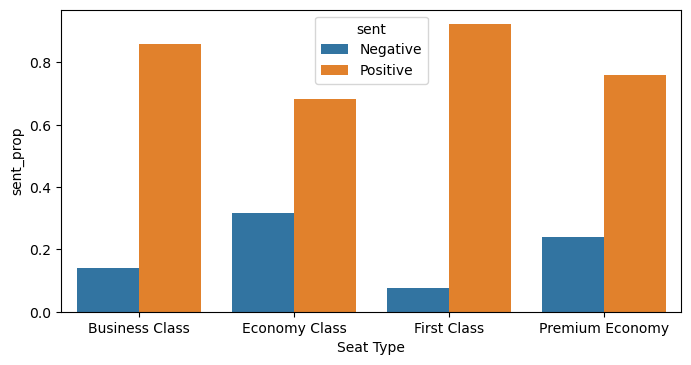

In [76]:
figure(figsize=(8, 4), dpi=100)
sns.barplot(data = canbin_sent_prop.dropna(), x = 'Seat Type', y = 'sent_prop', hue = 'sent')

### Domestic/International and sentiment

In [77]:
flight_type_sent = review_data_route[['flight_type','sent']
                                           ].groupby(['flight_type','sent']
                                                    ).agg({'sent':'count'}
                                                         ).rename(columns={'sent':'counts'}
                                                                 ).reset_index()

In [78]:
flight_type_prop = pd.merge(flight_type_sent, flight_type_sent.groupby('flight_type')[['counts']].sum().reset_index().rename(columns={'counts':'type_counts'}))

In [79]:
flight_type_prop['prop'] = flight_type_prop['counts']/flight_type_prop['type_counts']

<AxesSubplot:xlabel='flight_type', ylabel='prop'>

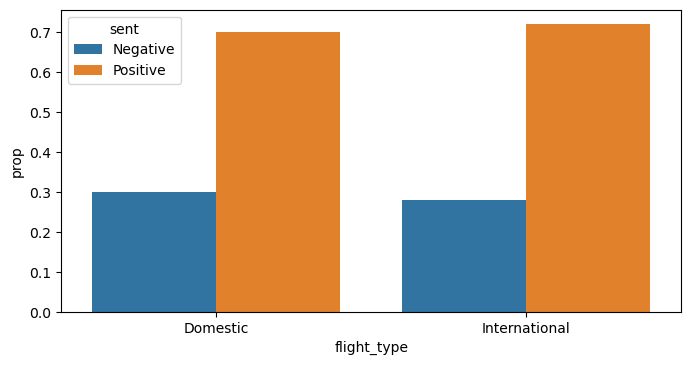

In [80]:
figure(figsize=(8, 4), dpi=100)
sns.barplot(data = flight_type_prop.dropna(), x = 'flight_type', y = 'prop', hue = 'sent')

### Transfer and sentiment

In [81]:
review_data_route['transfer_ind'] = np.where(review_data_route['transfers'].isnull(),'No','Yes')

In [82]:
transfer_count = review_data_route.groupby(['transfer_ind','sent']).agg({'sent':'count'}).rename(columns={'sent':'counts'}).reset_index()

In [83]:
transfer_count_prop = pd.merge(transfer_count, transfer_count.groupby('transfer_ind')[['counts']].sum().reset_index().rename(columns={'counts':'transfers_counts'}))

In [84]:
transfer_count_prop['prop'] = transfer_count_prop['counts']/transfer_count_prop['transfers_counts']

In [85]:
transfer_count_prop

,transfer_ind,sent,counts,transfers_counts,prop
0,No,Negative,359,1235,0.290688
1,No,Positive,876,1235,0.709312
2,Yes,Negative,108,413,0.261501
3,Yes,Positive,305,413,0.738499


## Review Cosine Similarity

In [86]:
docs = review_data_route['lemmizated'].to_list()

Apply TF-IDF and get word frequency.

In [87]:
tfidf_vectorizer = TfidfVectorizer()

In [88]:
sparse_matrix = tfidf_vectorizer.fit_transform(docs)

This produces a word frequency matrix from all reviews using TF-IDF.

In [89]:
doc_term_matrix = sparse_matrix.todense()
df = pd.DataFrame(doc_term_matrix,columns=tfidf_vectorizer.get_feature_names(),)
df.shape

(1648, 6258)

Compute cosine similarity.

In [90]:
cos_sim_matrix = cosine_similarity(df, df)

In [91]:
cos_distances = cosine_distances(df, df)
mds_map = MDS(dissimilarity='precomputed')
pos = mds_map.fit_transform(cos_distances)

In [92]:
sentiment_list = review_data_route['sent'].to_list()

In [93]:
colors = []
for s in sentiment_list:
    if s == 'Positive':
        colors.append('green')
    else:
        colors.append('blue')

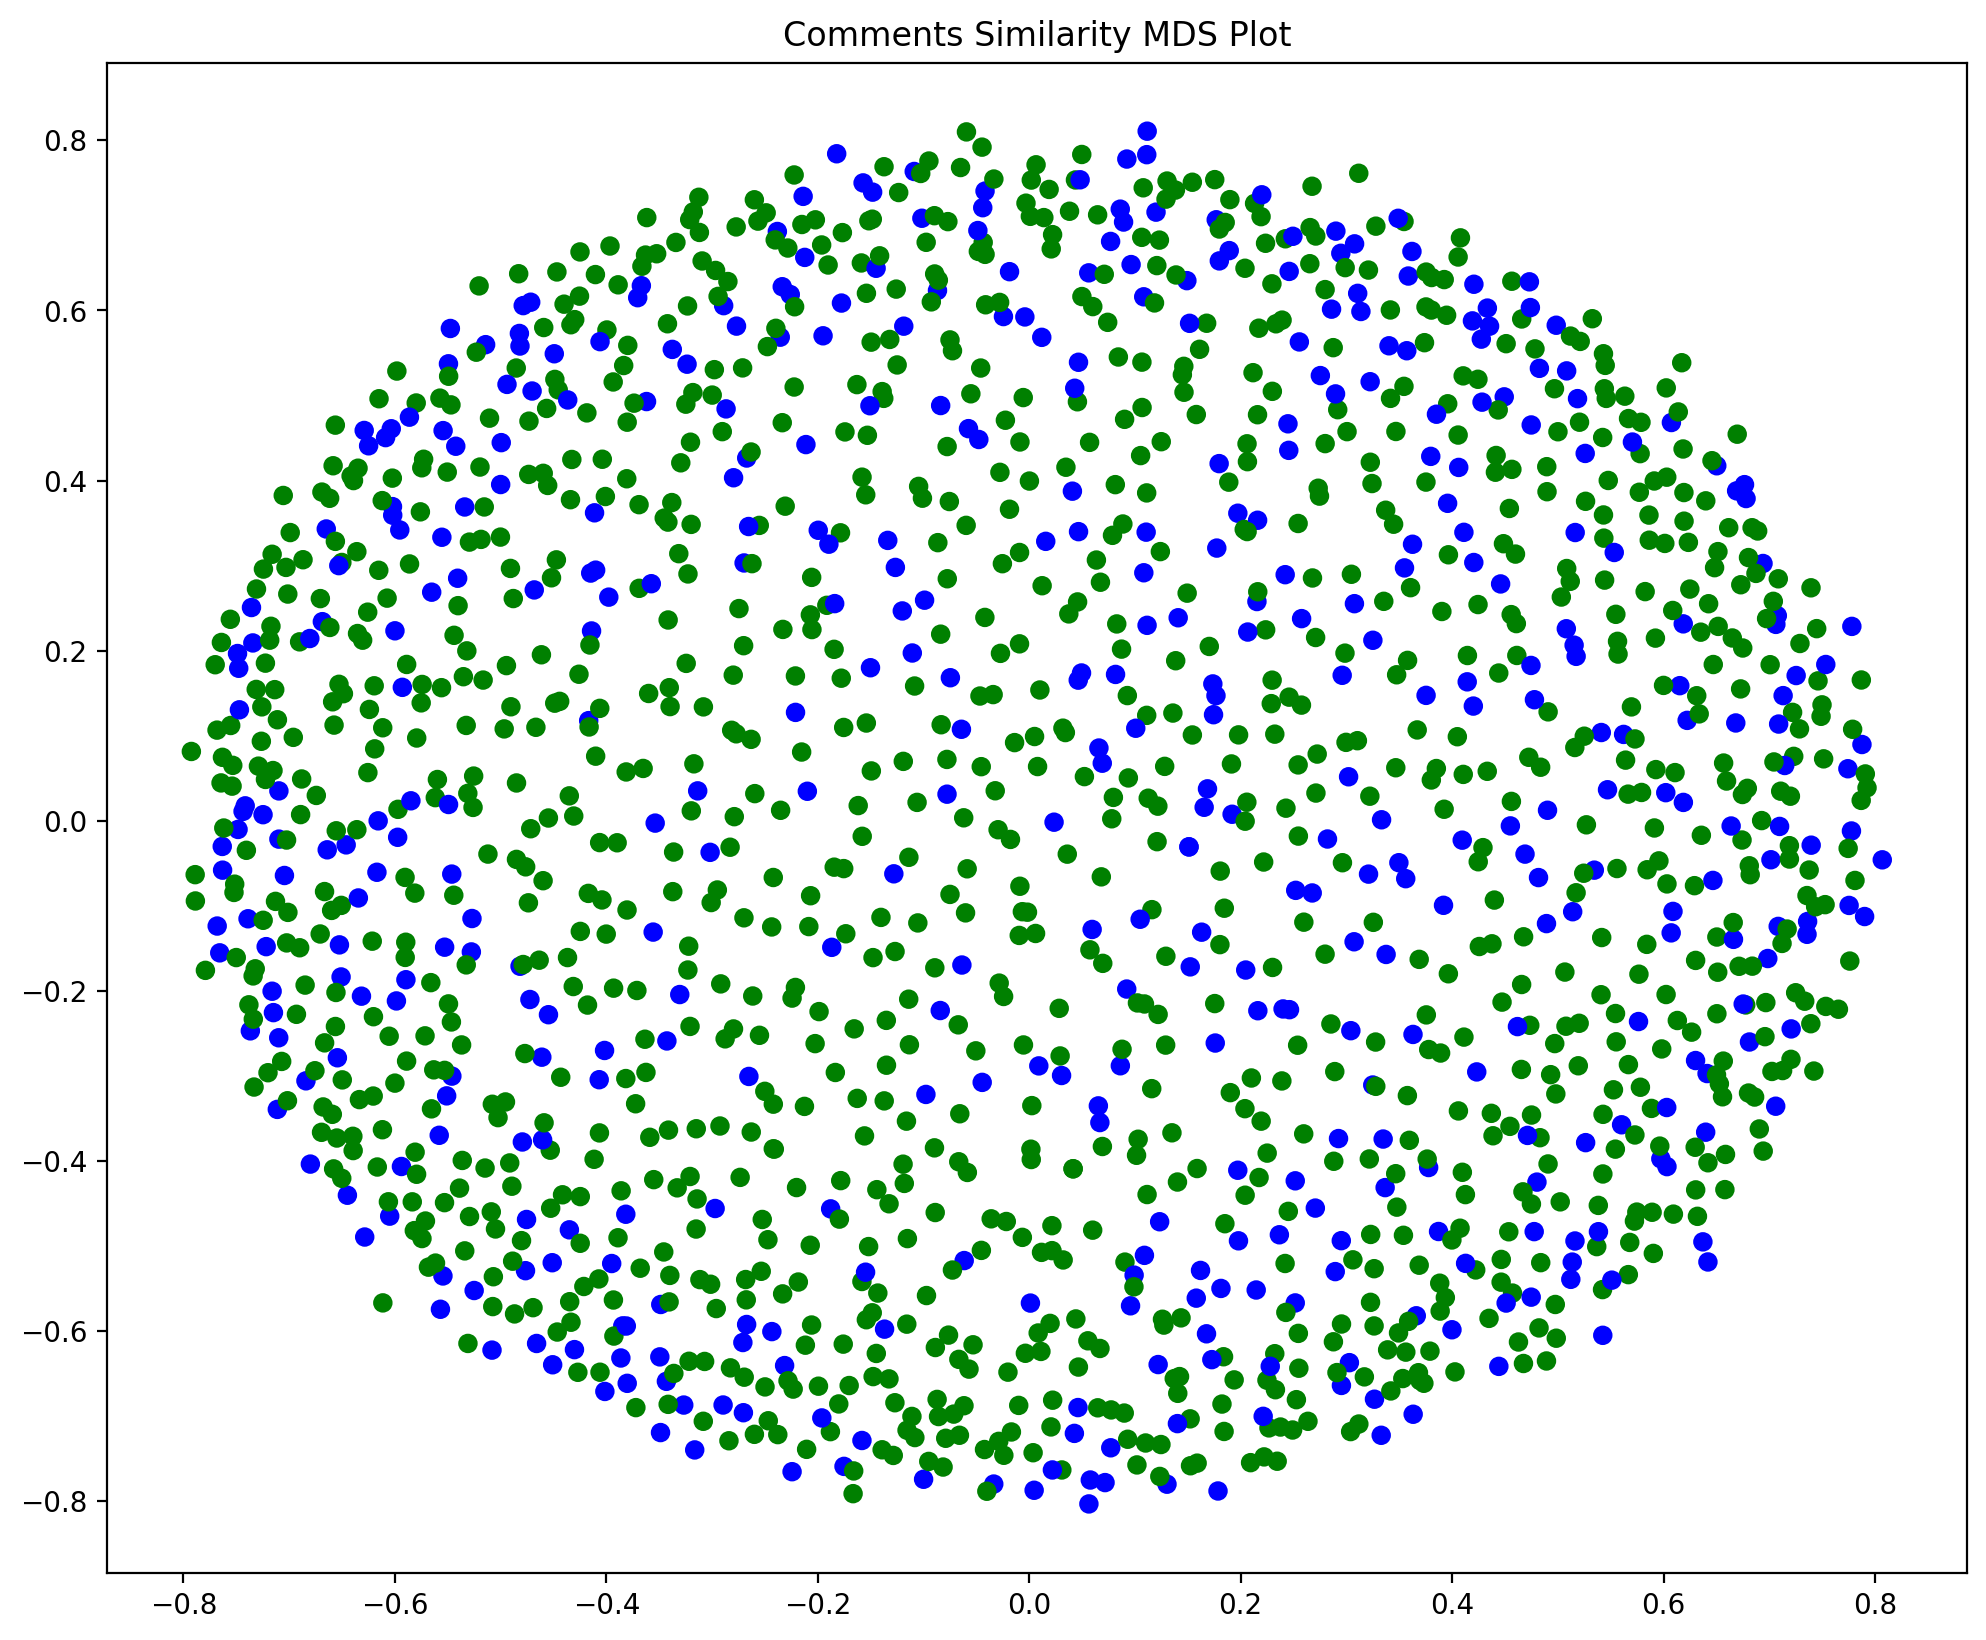

In [94]:
figure(figsize=(12, 10), dpi=200)
plt.scatter(pos[:,0],pos[:,1],c=colors)
plt.title('Comments Similarity MDS Plot')
plt.show()

There is no clear identification between positive and negative sentiment based on cosine similarity. This might be caused by the fact that reviews are concentrated with a few topics, with customers reflect to it in a positive or negative way. (e.g. service, delay)

This might also caused by MDS not being the best way visualizing cosine similarity here.

In [95]:
cosine_sim = cosine_similarity(df)

In [96]:
similar_score = list(enumerate(cosine_sim[i]))

find similar reviews based on similarity score > 0.15.

In [97]:
similar_ind = [x[0] for x in similar_score if x[1] > 0.15]

In [98]:
similar_reviews = review_data_route.iloc[similar_ind]

Mentioned cities

In [99]:
cities_list_sim = similar_reviews['cities'].to_list()
flattened_cities_sim = list(itertools.chain(*cities_list_sim))
cities_count_sim = Counter(flattened_cities_sim)
pd.DataFrame([[city,count] for city,count in cities_count_sim.items()],columns=['city','count']).sort_values(by='count',ascending=False).head(10)

,city,count
2,Toronto,20
7,Vancouver,8
1,Montreal,6
3,Calgary,4
9,Edmonton,3
0,Las Vegas,2
5,Chicago,2
8,Boston,2
34,New York,2
13,Paris,2


Sentiment distribution

<AxesSubplot:xlabel='sent', ylabel='Count'>

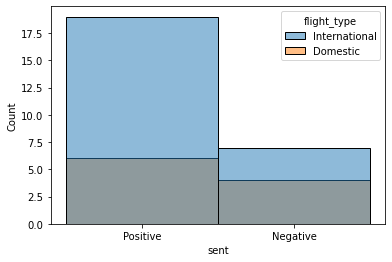

In [100]:
sns.histplot(data = similar_reviews,x='sent',hue='flight_type')

Most frequent keywords

In [101]:
def keep_keywords(lst):
    w = WordNetLemmatizer()
    new_lst = []
    for word_t in lst:
        if word_t[1] == 'n':
            new_lst.append(word_t[0])
    return new_lst

In [102]:
get_keywords = lambda x: keep_keywords(x)
lst_key_words = similar_reviews['pos'].apply(get_keywords)

In [103]:
keyword_lst = list(itertools.chain.from_iterable(lst_key_words))

In [104]:
counts = Counter(keyword_lst)
data_items = counts.items()
data_list = list(data_items)

In [105]:
word_freq_pd = pd.DataFrame(data_list,columns=['word','freq']).sort_values(by='freq',ascending=False)

In [106]:
word_freq_pd[~word_freq_pd.word.isin(['flight','air','canada'])].head(20)

,word,freq
17,customer,52
44,service,40
16,line,35
20,hour,33
115,luggage,30
62,time,29
2,toronto,26
166,plane,25
27,hours,24
144,day,23
